In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Constants
IMG_DIM = 180
BATCH_SIZE = 16
DATASET_PATH = "/kaggle/input/axialdb/Axial"
NUM_FOLDS = 5
SEED = 42
TOTAL_IMAGES = 5154
TRAIN_SIZE = 3607  # 70% of total dataset
TEST_SIZE = 1547   # 30% of total dataset

In [3]:
# Load dataset
data_loader = IDG(rescale=1./255).flow_from_directory(
    directory=DATASET_PATH, 
    target_size=(IMG_DIM, IMG_DIM), 
    batch_size=8000,  # Load all images
    shuffle=False
)
data, labels = next(data_loader)

# Shuffle dataset
data, labels = shuffle(data, labels, random_state=SEED)

# K-Fold Cross-Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

results = []

Found 5154 images belonging to 3 classes.


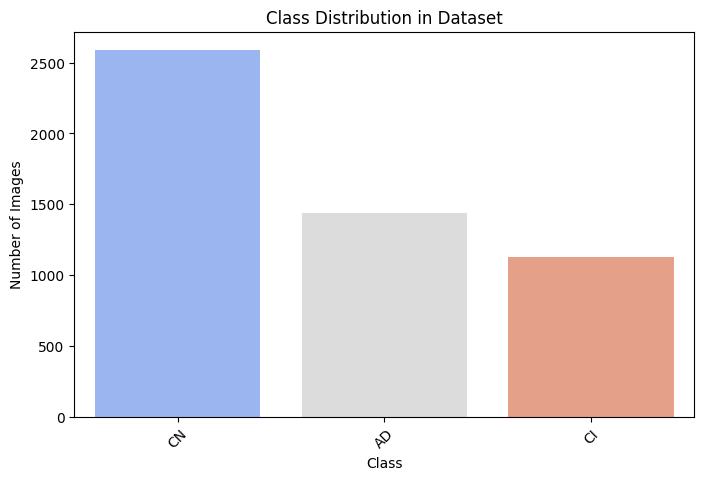

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Get class labels
class_labels = list(data_loader.class_indices.keys())

# Get class counts
label_counts = Counter(np.argmax(labels, axis=1))

# Convert to DataFrame for visualization
df_class_distribution = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
df_class_distribution.index = class_labels
df_class_distribution = df_class_distribution.sort_values(by="Count", ascending=False)

# Plot Class Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=df_class_distribution.index, y=df_class_distribution["Count"], palette="coolwarm")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()


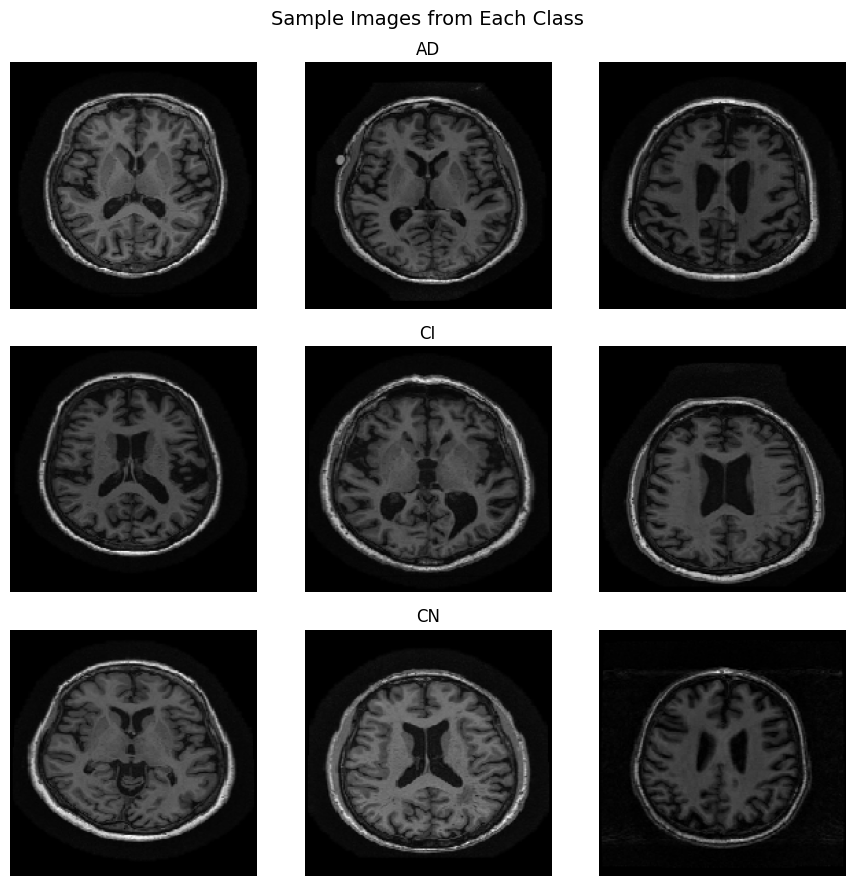

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(data_loader.class_indices.keys())

# Dictionary to store three samples per class
sample_images = {label: [] for label in range(len(class_labels))}

# Collect three images per class
for img, label in zip(data, labels):
    class_index = np.argmax(label)  # Convert one-hot to class index
    if len(sample_images[class_index]) < 3:  
        sample_images[class_index].append(img)  
    if all(len(imgs) == 3 for imgs in sample_images.values()):  
        break  # Stop when we have 3 images per class

# Plot the images
fig, axes = plt.subplots(len(class_labels), 3, figsize=(9, 3 * len(class_labels)))

for row, (class_index, imgs) in enumerate(sample_images.items()):
    for col, img in enumerate(imgs):
        ax = axes[row, col] if len(class_labels) > 1 else axes[col]  # Adjust for single-row case
        ax.imshow(img)
        ax.axis("off")
        if col == 1:  # Only set title for the middle image
            ax.set_title(class_labels[class_index])

plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()



Fold 1/5
Training size: 3607, Testing size: 1031
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.4221 - loss: 2.6120 - learning_rate: 0.0010
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5666 - loss: 1.1398 - learning_rate: 0.0010
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6035 - loss: 1.0305 - learning_rate: 0.0010
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5927 - loss: 1.0215 - learning_rate: 0.0010
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6547 - loss: 0.9115 - learning_rate: 0.0010
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7042 - loss: 0.7102 - learning_rate: 0.0010
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7159 - loss: 0.7063 - learning_rate: 0.0010
Epoch 8/10
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7030 - loss: 0.8849
Epoch 8: ReduceLROnPlateau reducin

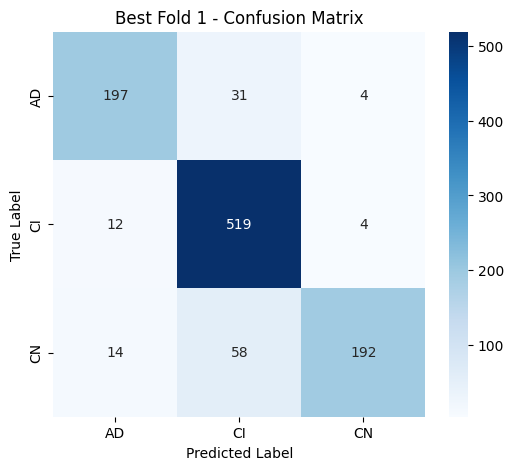

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Track the best model
best_model = None
best_score = 0  # Initialize the best accuracy score
best_fold = None
best_y_test = None
best_y_pred = None

for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")

    # Ensure exactly 3607 training & 1547 testing samples
    X_train, X_test = data[train_idx[:TRAIN_SIZE]], data[test_idx[:TEST_SIZE]]
    y_train, y_test = labels[train_idx[:TRAIN_SIZE]], labels[test_idx[:TEST_SIZE]]

    print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")

    # Load Pretrained ResNet50 Model
    base_model = ResNet50(input_shape=(IMG_DIM, IMG_DIM, 3), weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    # Custom layers
    x = Flatten()(base_model.output)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='loss', patience=3, mode='min')
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, verbose=2, mode='min')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, callbacks=[early_stop, lr_scheduler])

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  

    # Convert test labels if one-hot encoded
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

    # Check if this is the best model so far
    if accuracy > best_score:  # Change to F1-score if needed
        best_score = accuracy
        best_model = model
        best_fold = fold + 1
        best_y_test = y_test
        best_y_pred = y_pred

    # Store results
    results.append({
        'Fold': fold + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Calculate averages
avg_metrics = df_results.mean(numeric_only=True)

# Print results
print("\nCross-Validation Results:")
print(df_results)
print("\nAverage Metrics Across Folds:")
print(avg_metrics)

# Save the best model
if best_model:
    best_model.save("best_fold_model.h5")
    print(f"\n Best model from Fold {best_fold} saved as 'best_fold_model.h5' with Accuracy: {best_score:.4f}")

    # Save Confusion Matrix for Best Fold
    cm = confusion_matrix(best_y_test, best_y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["AD", "CI", "CN"], yticklabels=["AD", "CI", "CN"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Best Fold {best_fold} - Confusion Matrix")
    plt.savefig("best_fold_confusion_matrix.png")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


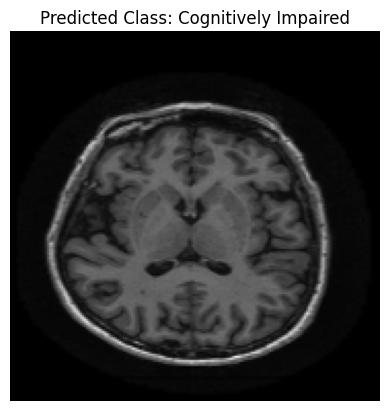

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model_path = "/kaggle/working/best_fold_model.h5"
model = load_model(model_path)  # Corrected model loading

# Load the image
image_path = "/kaggle/input/imagetest/Test_Image1.png"
target_shape = (180, 180)  # Desired shape for the input image
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.resize(image, target_shape)
image = image / 255.0  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Define class labels
class_names = ['Alzheimer Disease', 'Cognitively Impaired', 'Cognitively Normal']

# Make a prediction using the model
prediction = model.predict(image)

# Get the predicted class label
class_index = np.argmax(prediction)
predicted_class = class_names[class_index]

# Convert image back to uint8 for OpenCV display
image_uint8 = (image[0] * 255).astype(np.uint8)  # Convert float64 (0-1) to uint8 (0-255)

# Display the image and predicted class
plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


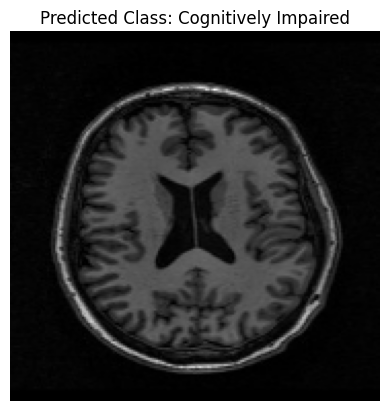

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model_path = "/kaggle/working/best_fold_model.h5"
model = load_model(model_path)  # Corrected model loading

# Load the image
image_path = "/kaggle/input/imagetest/Test_Image2.jpg"
target_shape = (180, 180)  # Desired shape for the input image
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.resize(image, target_shape)
image = image / 255.0  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Define class labels
class_names = ['Alzheimer Disease', 'Cognitively Impaired', 'Cognitively Normal']

# Make a prediction using the model
prediction = model.predict(image)

# Get the predicted class label
class_index = np.argmax(prediction)
predicted_class = class_names[class_index]

# Convert image back to uint8 for OpenCV display
image_uint8 = (image[0] * 255).astype(np.uint8)  # Convert float64 (0-1) to uint8 (0-255)

# Display the image and predicted class
plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


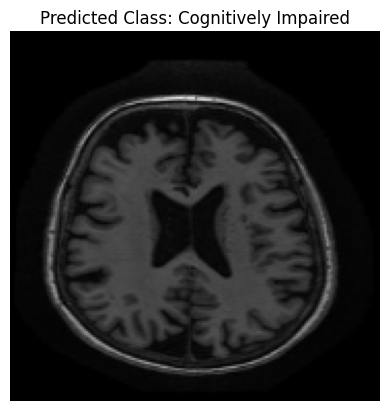

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model_path = "/kaggle/working/best_fold_model.h5"
model = load_model(model_path)  # Corrected model loading

# Load the image
image_path = "/kaggle/input/imagetest/Test_Image3.jpg"
target_shape = (180, 180)  # Desired shape for the input image
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.resize(image, target_shape)
image = image / 255.0  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Define class labels
class_names = ['Alzheimer Disease', 'Cognitively Impaired', 'Cognitively Normal']

# Make a prediction using the model
prediction = model.predict(image)

# Get the predicted class label
class_index = np.argmax(prediction)
predicted_class = class_names[class_index]

# Convert image back to uint8 for OpenCV display
image_uint8 = (image[0] * 255).astype(np.uint8)  # Convert float64 (0-1) to uint8 (0-255)

# Display the image and predicted class
plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()